<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/learned_image_compression/blob/main/notebooks/RateDistortionOptimizedAutoencoder_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rate/Distortion Optimized Autoencoder
Based on [Learned data compression](https://www.tensorflow.org/tutorials/generative/data_compression).

In [1]:
# We minimize: J = R + LAMBDA*D
# Notice that, if LAMBDA is high, we basically minimize D at the expense of increasing R as much as necessary), and viceversa.

In [2]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 4.3 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds
from keras.callbacks import Callback
import numpy as np
import keras
import os
from IPython.display import display, clear_output

In [4]:
training_dataset, validation_dataset = tfds.load(
    "cifar10",
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)
print(len(training_dataset), len(validation_dataset))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete527WVX/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete527WVX/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
40000 10000


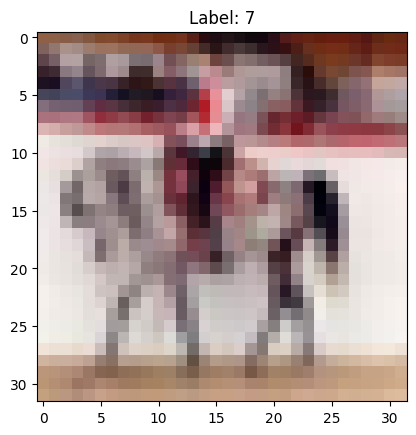

In [5]:
for image, label in training_dataset.take(1):
    # Display the image
    plt.imshow(image)
    plt.title(f"Label: {label.numpy()}")
    plt.show()

In [6]:
PRE_LATENT_SIZE = 2000
LATENT_SIZE = 100
EPOCHS = 100
LAMBDA = 500 #10000

# Original proposal.
#
# Analysis Transform architecture:
#
#            Ouput
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0  32*32*3      - Input: (height * width * depth)
#      20 16*16*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters
#      50   8*8*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*50 + 50 = 25050 parameters
#    2000     2000   fc_1 Dense(units=2000), 8*8*50*2000 + 2000 = 3200*2000 + 2000 = 6402000 parameters
#     100      100   fc_2 Dense(units=100), 2000*100 + 100 = 200100 parameters

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0      100      - Input: (100)
#    2000     2000   fc_1 Dense(units=2000), 100*2000 + 2000 = 202000 parameters
#    3200     3200   fc_2 Dense(units=3200), 2000*3200 + 3200 = 6403200 parameters, 8*8*50 = 3200
#      20 16*16*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 50 input channels of size 8*8, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*3 + 3 = 1503 parameters

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          3200, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# R=0.31640625 D=19.109853744506836, epoch 10, LAMBDA=500

In [7]:
PRE_LATENT_SIZE = 2000
LATENT_SIZE = 100
EPOCHS = 10

# Same architecture, but using strides=1.
#
# Analysis Transform architecture:
#
#            Ouput
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0  32*32*3      - Input: (height * width * depth)
#      20 32*32*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=(1, 1), padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters
#      50 32*32*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=(1, 1), padding="yes"), 20 input channels of size 32*32, 5*5*20*50 + 50 = 25050 parameters
#    2000     2000   fc_1 Dense(units=2000), 32*32*50*2000 + 2000 = 51200*2000 + 2000 = 102402000 parameters
#     100      100   fc_2 Dense(units=100), 2000*100 + 100 = 200100 parameters

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0      100      - Input: (100)
#    2000     2000   fc_1 Dense(units=2000), 100*2000 + 2000 = 202000 parameters
#    3200     3200   fc_2 Dense(units=3200), 2000*51200 + 51200 = 102451200 parameters, 32*32*50 = 51200
#      20 32*32*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(1, 1), padding="yes"), 50 input channels of size 32*32, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(1, 1), padding="yes"), 20 input channels of size 32*32, 5*5*20*3 + 3 = 1503 parameters

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          51200, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((32, 32, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# R=0.3193359375 D=18.908967971801758, epoch 6, LAMBDA=500

In [8]:
EPOCHS = 100
LAMBDA = 500 #10000
LATENT_SIZE = 8*8*50

# Using only convolutional layers, strides=2.
#
# Analysis Transform architecture:
#
#            Ouput
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0  32*32*3      - Input: (height * width * depth)
#      20 16*16*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters
#      50   8*8*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*50 + 50 = 25050 parameters

def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0   8*8*50      - Input: (3200)
#      20 16*16*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 50 input channels of size 8*8, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*3 + 3 = 1503 parameters

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((8, 8, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# R=9.2236328125 D=6.935627460479736, epoch 25, LAMBDA=500

In [9]:
EPOCHS = 100
LAMBDA = 500 #10000
LATENT_SIZE = 32*32*50

# Using only convolutional layers, strides=1.
#
# Analysis Transform architecture:
#
#            Ouput
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0  32*32*3      - Input: (height * width * depth)
#      20 32*32*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=(1, 1), padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters
#      50 32*32*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=(1, 1), padding="yes"), 20 input channels of size 32*32, 5*5*20*50 + 50 = 25050 parameters

def make_analysis_transform(latent_dims=100):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0 32*32*50      - Input: (3200)
#      20 32*32*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 50 input channels of size 8*8, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*3 + 3 = 1503 parameters

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((32, 32, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# Min val_loss: 18.3088, epoch 100, LAMBDA=500

In [10]:
EPOCHS = 100
LAMBDA = 500 #10000
PRE_LATENT_SIZE = 4096
LATENT_SIZE = 256

# Original proposal.
#
# Analysis Transform architecture:
#
#             Ouput
#  Number   Feature
#      of       Map
# Neurons     Shape   Name Info
# ======= ========= ====== =============...
#       0   32*32*3      - Input: (height * width * depth)
#     256 16*16*256 conv_1 Conv2D(filters=256, kernel_size=5, strides=(2, 2), padding="yes"), 3 input channels of size 32*32, 5*5*3*256 + 256 = 19456 parameters
#     256   8*8*256 conv_2 Conv2D(filters=256, kernel_size=5, strides=(2, 2), padding="yes"), 256 input channels of size 16*16, 5*5*256*256 + 256 = 1638656 parameters
#    4096      4096   fc_1 Dense(units=4096), 8*8*256*4096 + 4096 = 16384*4096 + 4096 = 67112960 parameters
#     256       256   fc_2 Dense(units=256), 4096*256 + 256 = 1048832 parameters

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0      256      - Input: (256)
#    4096     4096   fc_1 Dense(units=4096), 256*4096 + 4096 = 1052672 parameters
# 8*8*256    16384   fc_2 Dense(units=8*8*256), 2000*3200 + 3200 = 6403200 parameters, 8*8*50 = 3200 <------------------
#      20 16*16*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 50 input channels of size 8*8, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*3 + 3 = 1503 parameters

'''
___________________________
Model: "synthesis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #
=================================================================
 fc_1 (Dense)                (None, 4096)              1052672

 fc_2 (Dense)                (None, 16384)             67125248

 reshape (Reshape)           (None, 8, 8, 256)         0

 conv_1 (Conv2DTranspose)    (None, 16, 16, 256)       1638656

 conv_2 (Conv2DTranspose)    (None, 32, 32, 3)         19203

=================================================================
Total params: 69835779 (266.40 MB)
Trainable params: 69835779 (266.40 MB)
Non-trainable params: 0 (0.00 Byte)
'''
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          256*8*8, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 256)),
      tf.keras.layers.Conv2DTranspose(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# R=0.80078125 D=17.01704216003418, epoch 17, LAMBDA=500

In [11]:
'''PRE_LATENT_SIZE = 2000
LATENT_SIZE = 100

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          64, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          128*8*8, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 128)),
      tf.keras.layers.Conv2DTranspose(
          64, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder'''

'PRE_LATENT_SIZE = 2000\nLATENT_SIZE = 100\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          64, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          128, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_2"),\n      tf.keras.layers.Flatten(),\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),\n      tf.keras.layers.Dense(\n          latent_dims, use_bias=True, activation=None, name="fc_2"),\n  ], name="analysis_transform")\n  return encoder\n\ndef make_synthesis_transform():\n  """Creates the synthesis (decoder) transform."""\n  decoder = tf.keras.Sequential([\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1

In [12]:
'''PRE_LATENT_SIZE = 4096
LATENT_SIZE = 256

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Conv2D(
          512, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_3"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          512*4*4, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((4, 4, 512)),
      tf.keras.layers.Conv2DTranspose(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_3"),
  ], name="synthesis_transform")
  return decoder'''

'PRE_LATENT_SIZE = 4096\nLATENT_SIZE = 256\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          128, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          256, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_2"),\n      tf.keras.layers.Conv2D(\n          512, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_3"),\n      tf.keras.layers.Flatten(),\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),\n      tf.keras.layers.Dense(\n          latent_dims, use_bias=True, activation=None, name="fc_2"),\n  ], name="analysis_transform")\n  return encoder\n\ndef make_synthesis_transform():\n  """Creates the synthesis (decoder) transform.""

In [13]:
'''PRE_LATENT_SIZE = 4096
LATENT_SIZE = 256

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          256*8*8, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 256)),
      tf.keras.layers.Conv2DTranspose(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder'''

'PRE_LATENT_SIZE = 4096\nLATENT_SIZE = 256\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          128, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          256, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_2"),\n      tf.keras.layers.Flatten(),\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),\n      tf.keras.layers.Dense(\n          latent_dims, use_bias=True, activation=None, name="fc_2"),\n  ], name="analysis_transform")\n  return encoder\n\ndef make_synthesis_transform():\n  """Creates the synthesis (decoder) transform."""\n  decoder = tf.keras.Sequential([\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_

In [14]:
class CompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor."""

  def __init__(self, latent_dims=LATENT_SIZE):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 32, 32, 3))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per image.
    rate = tf.reduce_mean(rate)

    # Divide rate by the number of neurons in the latent space. This normalizes the rate in bits/neuron.
    rate /= tf.cast(tf.shape(y)[1], dtype=tf.float32)

    # Mean absolute difference across pixels.
    #distortion = tf.reduce_mean(abs(x - x_tilde))
    distortion = tf.sqrt(tf.reduce_mean((x - x_tilde)*(x - x_tilde))) # RMSE
    #distortion = tf.reduce_mean((x - x_tilde)*(x - x_tilde))
    #tf.print(rate, distortion)

    return dict(rate=rate, distortion=distortion)

In [15]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_compression_trainer(lmbda, latent_dims=LATENT_SIZE):
  trainer = CompressionTrainer(latent_dims)
  #custom_metric = MeanMetricWrapper()
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

In [16]:
class MyCallback(Callback):
    def __init__(self, file_prefix='model_parameters'):
        super(MyCallback, self).__init__()
        self.file_prefix = file_prefix
        self.losses = []

    def on_train_begin(self, logs=None):
        prev_trained_model = os.path.exists("autoencoder_weights.h5")
        if prev_trained_model:
            print(f"Using weights previously generated")
            #self.model = tf.keras.models.load_model("model", custom_objects={'MeanMetricWrapper': MeanMetricWrapper, 'pass_through_loss': pass_through_loss})
            #self.model = keras.models.load_model("model", custom_objects=dict(rate=pass_through_loss, distortion=pass_through_loss))
            x_batch_ = validation_dataset.batch(1).skip(3).take(1)
            # Extract the element from the batch to get a tensor
            x_ = next(iter(x_batch_))
            x_image, _ = x_
            #print(x_)
            _ = self.model(x_image)
            '''
            self.model = make_compression_trainer(LAMBDA)
            self.model.analysis_transform.summary()
            self.model.synthesis_transform.summary()
            self.model.prior_log_scales.summary()
            # Build the model by calling it with dummy input data
            #dummy_input = tf.zeros((1, input_shape))  # Replace input_shape with the actual input shape
            '''
            #self.model.analysis_transform.summary()
            #self.model.synthesis_transform.summary()
            self.model.load_weights("autoencoder_weights.h5")
        else:
            print("No saved weights found. Training from scratch.")

    def on_epoch_end(self, epoch, logs=None):
        '''
        # Get the model's weights
        model_weights = self.model.get_weights()

        # Save the weights to a file
        file_name = f"{self.file_prefix}_epoch_{epoch + 1}.npy"
        np.save(file_name, model_weights)
        print(f"Saved model parameters at the end of epoch {epoch + 1} to {file_name}")
        '''
        #keras.models.save_model(self.model, "model", custom_objects=dict(rate=pass_through_loss, distortion=pass_through_loss))
        #print("Model saved.")
        self.model.save_weights("autoencoder_weights.h5")
        print("\nSaved weights.")

        x_batch = validation_dataset.batch(1).skip(3).take(1)
        # Extract the element from the batch to get a tensor
        x = next(iter(x_batch))
        x_image, _ = x
        x_image = x_image.numpy().squeeze().astype(np.uint8)
        y = self.model.analysis_transform(x)
        entropy_model = tfc.ContinuousBatchedEntropyModel(self.model.prior, coding_rank=1, compression=True)
        y_tilde, rate = entropy_model(y, training=False)
        y_tilde_codestream = entropy_model.compress(y)
        x_tilde = self.model.synthesis_transform(y_tilde)[0]
        #rate /= LATENT_SIZE
        #rate /= (32*32)
        #rate = tf.size(y_tilde)/(32*32)
        #print("len=", len(y_tilde_codestream.numpy()[0]))
        bit_rate_in_bits_per_pixel = len(y_tilde_codestream.numpy()[0]) / (32*32)
        distortion = tf.sqrt(tf.reduce_mean((x_image - x_tilde)*(x_image - x_tilde))) # RMSE
        print(f"R={bit_rate_in_bits_per_pixel} D={distortion} D+R={bit_rate_in_bits_per_pixel + distortion} LATENT_SIZE={LATENT_SIZE}")

        #clear_output(wait=True)
        plt.subplot(1, 3, 1)
        plt.imshow(x_image)
        plt.subplot(1, 3, 2)
        plt.imshow(x_tilde.numpy().astype(np.uint8))
        if logs is not None and 'val_loss' in logs:
            self.losses.append(logs['val_loss'])
            plt.subplot(1, 3, 3)
            plt.plot(range(1, len(self.losses) + 1), self.losses, marker='o', linestyle='-', color='b')
            plt.title('Validation Loss Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Loss (J)')

        '''
        fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(6, 2))
        axes = axes.ravel()
        x_batch = validation_dataset.batch(1).skip(3).take(1)
        # Extract the element from the batch to get a tensor
        x = next(iter(x_batch))
        x_image, _ = x
        axes[0].imshow(x_image.numpy().squeeze().astype(np.uint8))
        y = self.model.analysis_transform(x)
        entropy_model = tfc.ContinuousBatchedEntropyModel(self.model.prior, coding_rank=1, compression=False)
        y_tilde, rate = entropy_model(y, training=False)
        x_tilde = self.model.synthesis_transform(y_tilde)[0]
        axes[1].imshow(x_tilde.numpy().astype(np.uint8))
        if logs is not None and 'loss' in logs:
            self.losses.append(logs['loss'])
            clear_output(wait=True)
            axes[2].plot(range(1, len(self.losses) + 1), self.losses, marker='o', linestyle='-', color='b')
            #axes[2].title('Training Loss Over Epochs')
            axes[2].xlabel('Epoch')
            axes[2].ylabel('Loss')
        '''

        plt.tight_layout()
        plt.show()

        #y_tilde, rate = self.model.entropy_model(y, training=training)
        '''
        #x_tilde = self.synthesis_transform(y_tilde)

        # Average number of bits per image.
        rate = tf.reduce_mean(rate)

        # Divide rate by the number of neurons in the latent space. This normalizes the rate in bits/neuron.
        rate /= tf.cast(tf.shape(y)[1], dtype=tf.float32)

        # Mean absolute difference across pixels.
        #distortion = tf.reduce_mean(abs(x - x_tilde))
        distortion = tf.sqrt(tf.reduce_mean((x - x_tilde)*(x - x_tilde))) # RMSE
        '''

In [17]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def __train_model(lmbda=LAMBDA, epochs=EPOCHS):
  callbacks_list = [MyCallback()]
  trainer = make_compression_trainer(lmbda)
  for i in range(EPOCHS):
    trainer.fit(
        training_dataset.map(add_rd_targets).batch(128).prefetch(8),
        epochs=1,
        validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
        validation_freq=1,
        verbose=1,
        callbacks=callbacks_list
    )
  return trainer

Epoch: 0
No saved weights found. Training from scratch.
  6/313 [..............................] - ETA: 35s - loss: 694.9268 - distortion_loss: 1.3835 - rate_loss: 3.1887 - distortion_pass_through_loss: 1.3835 - rate_pass_through_loss: 3.1887

313/313 [==============================] - ETA: 0s - loss: 141.7183 - distortion_loss: 0.2781 - rate_loss: 2.6663 - distortion_pass_through_loss: 0.2779 - rate_pass_through_loss: 2.6657


Saved weights.
R=0.71875 D=34.049686431884766 D+R=34.768436431884766 LATENT_SIZE=256


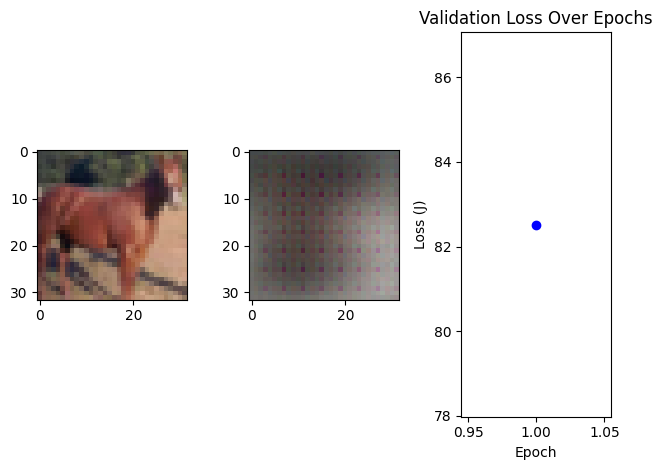

313/313 [==============================] - 65s 156ms/step - loss: 141.7183 - distortion_loss: 0.2781 - rate_loss: 2.6663 - distortion_pass_through_loss: 0.2779 - rate_pass_through_loss: 2.6657 - val_loss: 82.5208 - val_distortion_loss: 0.1606 - val_rate_loss: 2.2457 - val_distortion_pass_through_loss: 0.1606 - val_rate_pass_through_loss: 2.2460
Model: "analysis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 16, 16, 256)       19456     
                                                                 
 conv_2 (Conv2D)             (None, 8, 8, 256)         1638656   
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 fc_1 (Dense)                (None, 4096)              67112960  
                               

313/313 [==============================] - ETA: 0s - loss: 73.9428 - distortion_loss: 0.1435 - rate_loss: 2.1821 - distortion_pass_through_loss: 0.1435 - rate_pass_through_loss: 2.1821
Saved weights.
R=0.734375 D=25.710693359375 D+R=26.445068359375 LATENT_SIZE=256


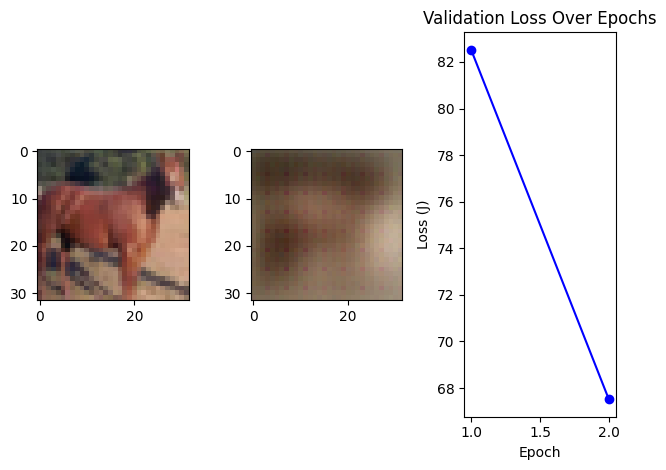

313/313 [==============================] - 47s 150ms/step - loss: 73.9428 - distortion_loss: 0.1435 - rate_loss: 2.1821 - distortion_pass_through_loss: 0.1435 - rate_pass_through_loss: 2.1821 - val_loss: 67.5193 - val_distortion_loss: 0.1307 - val_rate_loss: 2.1473 - val_distortion_pass_through_loss: 0.1308 - val_rate_pass_through_loss: 2.1475
Epoch: 2
Using weights previously generated
  6/313 [..............................] - ETA: 37s - loss: 67.2298 - distortion_loss: 0.1302 - rate_loss: 2.1466 - distortion_pass_through_loss: 0.1302 - rate_pass_through_loss: 2.1466

313/313 [==============================] - ETA: 0s - loss: 63.4859 - distortion_loss: 0.1227 - rate_loss: 2.1560 - distortion_pass_through_loss: 0.1227 - rate_pass_through_loss: 2.1561
Saved weights.
R=0.759765625 D=23.691226959228516 D+R=24.450992584228516 LATENT_SIZE=256


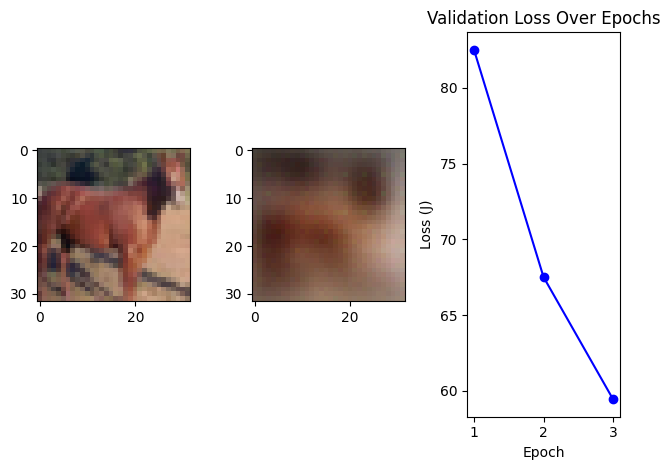

313/313 [==============================] - 50s 158ms/step - loss: 63.4859 - distortion_loss: 0.1227 - rate_loss: 2.1560 - distortion_pass_through_loss: 0.1227 - rate_pass_through_loss: 2.1561 - val_loss: 59.4488 - val_distortion_loss: 0.1145 - val_rate_loss: 2.1744 - val_distortion_pass_through_loss: 0.1146 - val_rate_pass_through_loss: 2.1750
Epoch: 3
Using weights previously generated
  6/313 [..............................] - ETA: 38s - loss: 59.9212 - distortion_loss: 0.1155 - rate_loss: 2.1778 - distortion_pass_through_loss: 0.1155 - rate_pass_through_loss: 2.1778

313/313 [==============================] - ETA: 0s - loss: 57.8280 - distortion_loss: 0.1113 - rate_loss: 2.1923 - distortion_pass_through_loss: 0.1113 - rate_pass_through_loss: 2.1925
Saved weights.
R=0.77734375 D=22.19181251525879 D+R=22.96915626525879 LATENT_SIZE=256


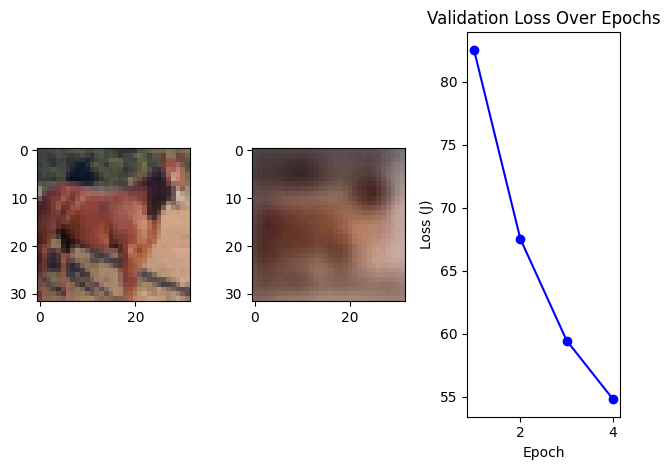

313/313 [==============================] - 50s 158ms/step - loss: 57.8280 - distortion_loss: 0.1113 - rate_loss: 2.1923 - distortion_pass_through_loss: 0.1113 - rate_pass_through_loss: 2.1925 - val_loss: 54.7979 - val_distortion_loss: 0.1051 - val_rate_loss: 2.2455 - val_distortion_pass_through_loss: 0.1051 - val_rate_pass_through_loss: 2.2466
Epoch: 4
Using weights previously generated
  6/313 [..............................] - ETA: 38s - loss: 54.4235 - distortion_loss: 0.1044 - rate_loss: 2.2413 - distortion_pass_through_loss: 0.1044 - rate_pass_through_loss: 2.2413

313/313 [==============================] - ETA: 0s - loss: 52.5056 - distortion_loss: 0.1005 - rate_loss: 2.2795 - distortion_pass_through_loss: 0.1005 - rate_pass_through_loss: 2.2798
Saved weights.
R=0.7802734375 D=21.79474639892578 D+R=22.57501983642578 LATENT_SIZE=256


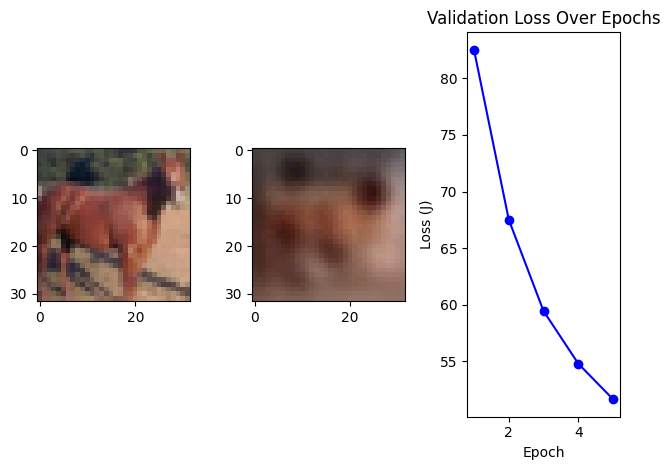

313/313 [==============================] - 50s 161ms/step - loss: 52.5056 - distortion_loss: 0.1005 - rate_loss: 2.2795 - distortion_pass_through_loss: 0.1005 - rate_pass_through_loss: 2.2798 - val_loss: 51.6523 - val_distortion_loss: 0.0987 - val_rate_loss: 2.3220 - val_distortion_pass_through_loss: 0.0987 - val_rate_pass_through_loss: 2.3228
Epoch: 5
Using weights previously generated
  6/313 [..............................] - ETA: 39s - loss: 50.7566 - distortion_loss: 0.0969 - rate_loss: 2.3202 - distortion_pass_through_loss: 0.0969 - rate_pass_through_loss: 2.3202

313/313 [==============================] - ETA: 0s - loss: 49.2088 - distortion_loss: 0.0937 - rate_loss: 2.3625 - distortion_pass_through_loss: 0.0937 - rate_pass_through_loss: 2.3627
Saved weights.
R=0.7783203125 D=20.218212127685547 D+R=20.996532440185547 LATENT_SIZE=256


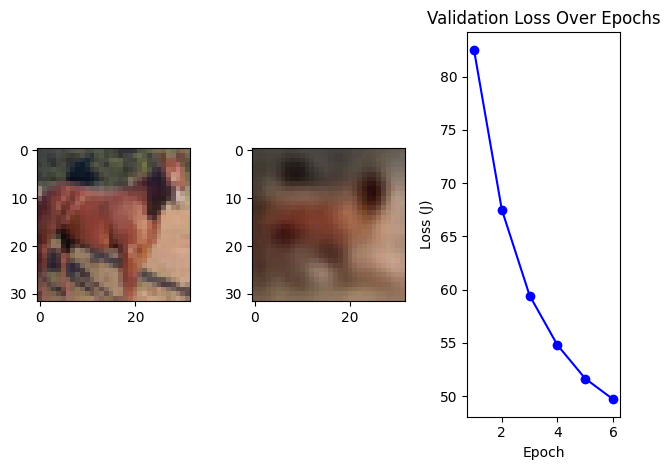

313/313 [==============================] - 53s 169ms/step - loss: 49.2088 - distortion_loss: 0.0937 - rate_loss: 2.3625 - distortion_pass_through_loss: 0.0937 - rate_pass_through_loss: 2.3627 - val_loss: 49.7117 - val_distortion_loss: 0.0947 - val_rate_loss: 2.3718 - val_distortion_pass_through_loss: 0.0947 - val_rate_pass_through_loss: 2.3727
Epoch: 6
Using weights previously generated
  6/313 [..............................] - ETA: 38s - loss: 48.2013 - distortion_loss: 0.0917 - rate_loss: 2.3672 - distortion_pass_through_loss: 0.0917 - rate_pass_through_loss: 2.3672

313/313 [==============================] - ETA: 0s - loss: 46.5192 - distortion_loss: 0.0881 - rate_loss: 2.4476 - distortion_pass_through_loss: 0.0882 - rate_pass_through_loss: 2.4478
Saved weights.
R=0.7763671875 D=19.492284774780273 D+R=20.268651962280273 LATENT_SIZE=256


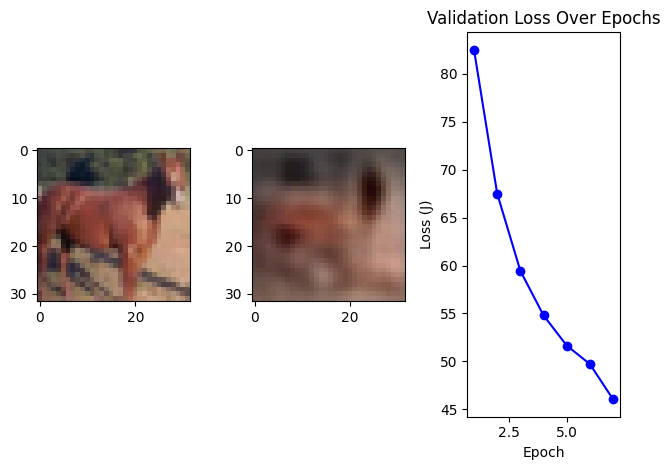

313/313 [==============================] - 52s 166ms/step - loss: 46.5192 - distortion_loss: 0.0881 - rate_loss: 2.4476 - distortion_pass_through_loss: 0.0882 - rate_pass_through_loss: 2.4478 - val_loss: 46.0423 - val_distortion_loss: 0.0872 - val_rate_loss: 2.4553 - val_distortion_pass_through_loss: 0.0872 - val_rate_pass_through_loss: 2.4560
Epoch: 7
Using weights previously generated
  6/313 [..............................] - ETA: 40s - loss: 47.2091 - distortion_loss: 0.0895 - rate_loss: 2.4440 - distortion_pass_through_loss: 0.0895 - rate_pass_through_loss: 2.4440

313/313 [==============================] - ETA: 0s - loss: 44.3746 - distortion_loss: 0.0837 - rate_loss: 2.5296 - distortion_pass_through_loss: 0.0837 - rate_pass_through_loss: 2.5297
Saved weights.
R=0.783203125 D=18.849702835083008 D+R=19.632905960083008 LATENT_SIZE=256


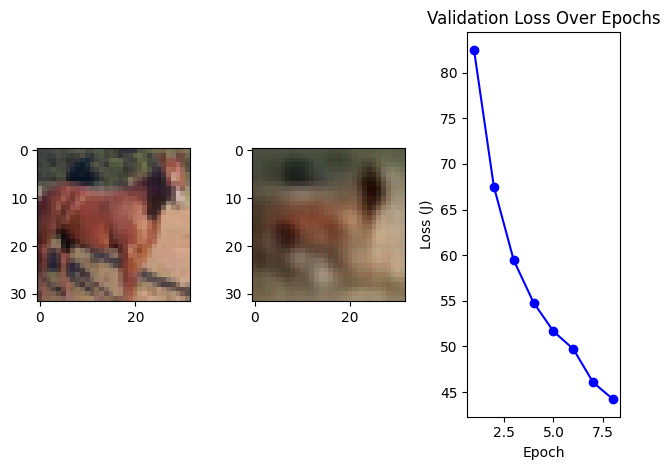

313/313 [==============================] - 53s 168ms/step - loss: 44.3746 - distortion_loss: 0.0837 - rate_loss: 2.5296 - distortion_pass_through_loss: 0.0837 - rate_pass_through_loss: 2.5297 - val_loss: 44.2057 - val_distortion_loss: 0.0834 - val_rate_loss: 2.5205 - val_distortion_pass_through_loss: 0.0834 - val_rate_pass_through_loss: 2.5209
Epoch: 8
Using weights previously generated
  6/313 [..............................] - ETA: 37s - loss: 44.1260 - distortion_loss: 0.0832 - rate_loss: 2.5097 - distortion_pass_through_loss: 0.0832 - rate_pass_through_loss: 2.5097

313/313 [==============================] - ETA: 0s - loss: 43.9545 - distortion_loss: 0.0828 - rate_loss: 2.5650 - distortion_pass_through_loss: 0.0828 - rate_pass_through_loss: 2.5652
Saved weights.
R=0.7724609375 D=18.461862564086914 D+R=19.234323501586914 LATENT_SIZE=256


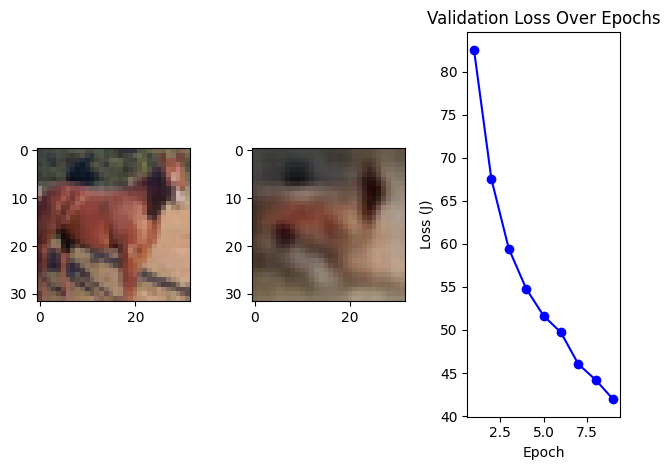

313/313 [==============================] - 58s 184ms/step - loss: 43.9545 - distortion_loss: 0.0828 - rate_loss: 2.5650 - distortion_pass_through_loss: 0.0828 - rate_pass_through_loss: 2.5652 - val_loss: 41.9567 - val_distortion_loss: 0.0787 - val_rate_loss: 2.5946 - val_distortion_pass_through_loss: 0.0788 - val_rate_pass_through_loss: 2.5950
Epoch: 9
Using weights previously generated
  6/313 [..............................] - ETA: 37s - loss: 42.0738 - distortion_loss: 0.0790 - rate_loss: 2.5862 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 2.5862

313/313 [==============================] - ETA: 0s - loss: 40.7167 - distortion_loss: 0.0761 - rate_loss: 2.6723 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 2.6726
Saved weights.
R=0.7744140625 D=16.648452758789062 D+R=17.422866821289062 LATENT_SIZE=256


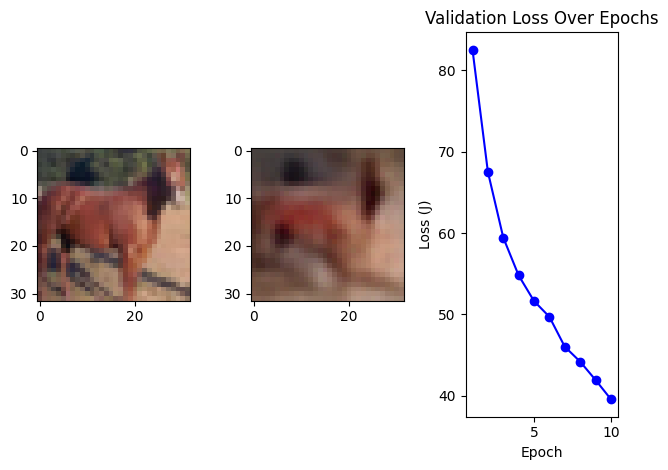

313/313 [==============================] - 51s 163ms/step - loss: 40.7167 - distortion_loss: 0.0761 - rate_loss: 2.6723 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 2.6726 - val_loss: 39.5838 - val_distortion_loss: 0.0737 - val_rate_loss: 2.7211 - val_distortion_pass_through_loss: 0.0738 - val_rate_pass_through_loss: 2.7215
Epoch: 10
Using weights previously generated
  6/313 [..............................] - ETA: 38s - loss: 39.9586 - distortion_loss: 0.0745 - rate_loss: 2.7133 - distortion_pass_through_loss: 0.0745 - rate_pass_through_loss: 2.7133

313/313 [==============================] - ETA: 0s - loss: 39.1015 - distortion_loss: 0.0727 - rate_loss: 2.7488 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 2.7489
Saved weights.
R=0.78125 D=16.411449432373047 D+R=17.192699432373047 LATENT_SIZE=256


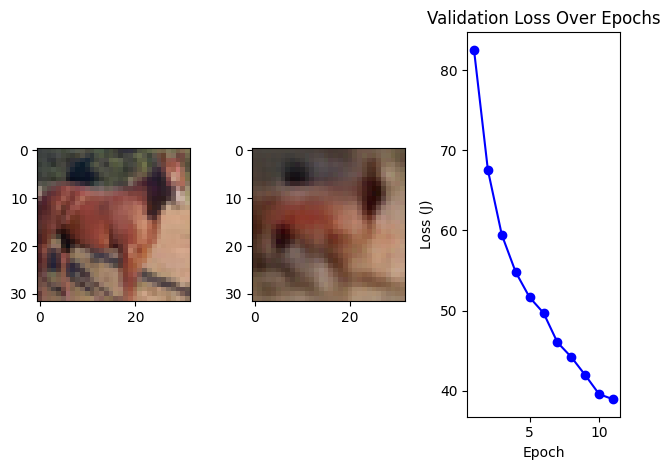

313/313 [==============================] - 49s 156ms/step - loss: 39.1015 - distortion_loss: 0.0727 - rate_loss: 2.7488 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 2.7489 - val_loss: 38.9513 - val_distortion_loss: 0.0724 - val_rate_loss: 2.7379 - val_distortion_pass_through_loss: 0.0725 - val_rate_pass_through_loss: 2.7383
Epoch: 11
Using weights previously generated
  6/313 [..............................] - ETA: 37s - loss: 39.1318 - distortion_loss: 0.0728 - rate_loss: 2.7316 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 2.7316

313/313 [==============================] - ETA: 0s - loss: 38.6702 - distortion_loss: 0.0718 - rate_loss: 2.7658 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 2.7660
Saved weights.
R=0.79296875 D=16.06049919128418 D+R=16.85346794128418 LATENT_SIZE=256


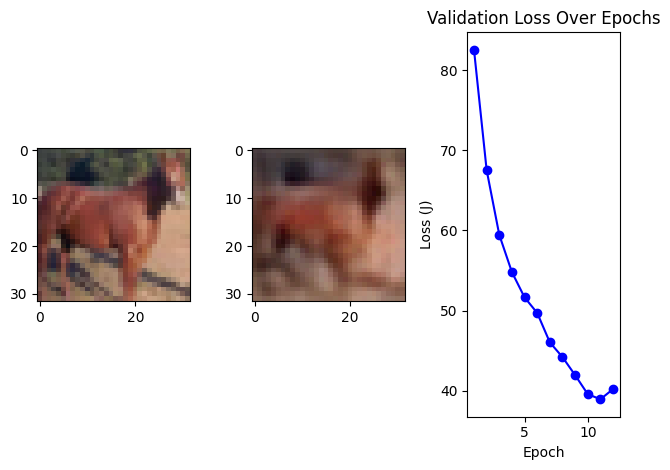

313/313 [==============================] - 53s 170ms/step - loss: 38.6702 - distortion_loss: 0.0718 - rate_loss: 2.7658 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 2.7660 - val_loss: 40.2180 - val_distortion_loss: 0.0748 - val_rate_loss: 2.8025 - val_distortion_pass_through_loss: 0.0749 - val_rate_pass_through_loss: 2.8029
Epoch: 12
Using weights previously generated
  6/313 [..............................] - ETA: 39s - loss: 38.9040 - distortion_loss: 0.0722 - rate_loss: 2.7807 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 2.7807

313/313 [==============================] - ETA: 0s - loss: 37.7794 - distortion_loss: 0.0700 - rate_loss: 2.8036 - distortion_pass_through_loss: 0.0699 - rate_pass_through_loss: 2.8037
Saved weights.
R=0.79296875 D=15.885540962219238 D+R=16.678508758544922 LATENT_SIZE=256


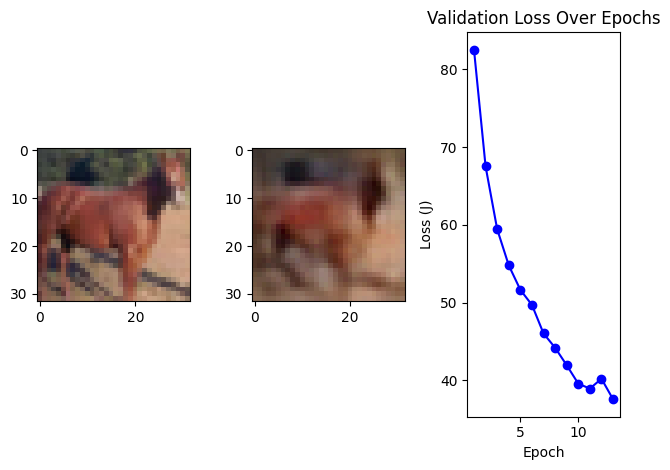

313/313 [==============================] - 53s 171ms/step - loss: 37.7794 - distortion_loss: 0.0700 - rate_loss: 2.8036 - distortion_pass_through_loss: 0.0699 - rate_pass_through_loss: 2.8037 - val_loss: 37.5802 - val_distortion_loss: 0.0695 - val_rate_loss: 2.8340 - val_distortion_pass_through_loss: 0.0695 - val_rate_pass_through_loss: 2.8343
Epoch: 13
Using weights previously generated
  6/313 [..............................] - ETA: 38s - loss: 39.8544 - distortion_loss: 0.0741 - rate_loss: 2.8285 - distortion_pass_through_loss: 0.0741 - rate_pass_through_loss: 2.8285

313/313 [==============================] - ETA: 0s - loss: 37.0639 - distortion_loss: 0.0685 - rate_loss: 2.8170 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 2.8172
Saved weights.
R=0.794921875 D=19.099626541137695 D+R=19.894548416137695 LATENT_SIZE=256


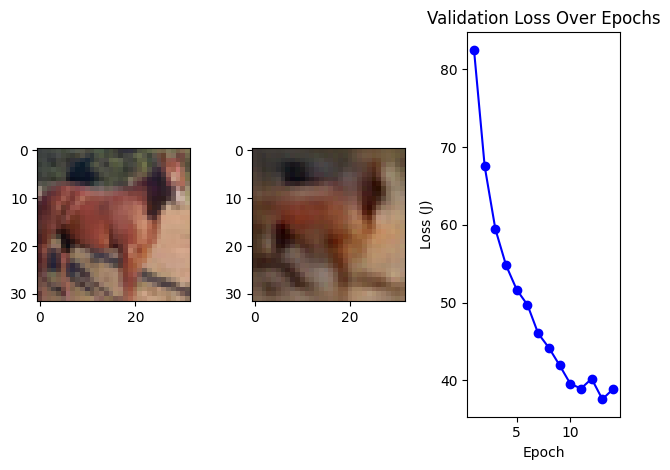

313/313 [==============================] - 52s 165ms/step - loss: 37.0639 - distortion_loss: 0.0685 - rate_loss: 2.8170 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 2.8172 - val_loss: 38.8885 - val_distortion_loss: 0.0720 - val_rate_loss: 2.8779 - val_distortion_pass_through_loss: 0.0721 - val_rate_pass_through_loss: 2.8782
Epoch: 14
Using weights previously generated
  6/313 [..............................] - ETA: 37s - loss: 36.3809 - distortion_loss: 0.0670 - rate_loss: 2.8902 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 2.8902

313/313 [==============================] - ETA: 0s - loss: 36.2284 - distortion_loss: 0.0668 - rate_loss: 2.8517 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 2.8519
Saved weights.
R=0.7998046875 D=15.543594360351562 D+R=16.343399047851562 LATENT_SIZE=256


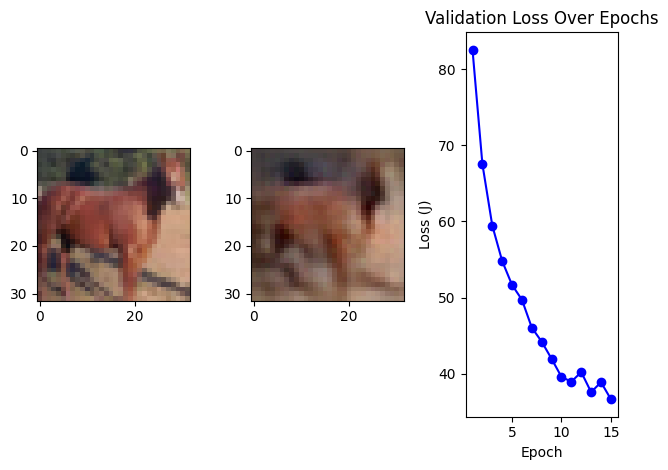

313/313 [==============================] - 51s 162ms/step - loss: 36.2284 - distortion_loss: 0.0668 - rate_loss: 2.8517 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 2.8519 - val_loss: 36.6487 - val_distortion_loss: 0.0675 - val_rate_loss: 2.8927 - val_distortion_pass_through_loss: 0.0675 - val_rate_pass_through_loss: 2.8929
Epoch: 15
Using weights previously generated
  6/313 [..............................] - ETA: 38s - loss: 34.6504 - distortion_loss: 0.0635 - rate_loss: 2.9015 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 2.9015

313/313 [==============================] - ETA: 0s - loss: 35.4055 - distortion_loss: 0.0651 - rate_loss: 2.8798 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 2.8800
Saved weights.
R=0.79296875 D=15.321969985961914 D+R=16.114938735961914 LATENT_SIZE=256


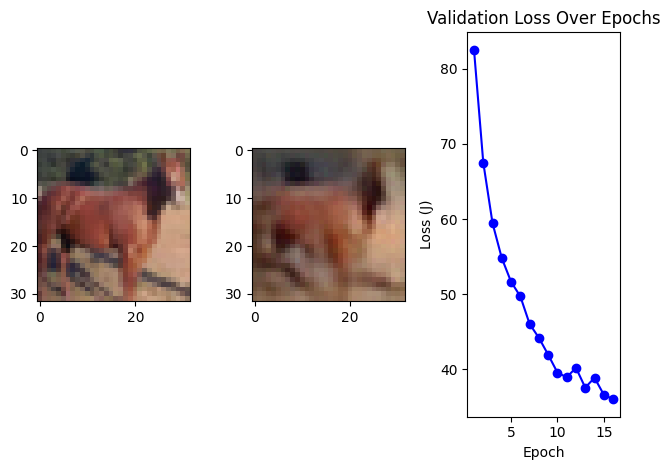

313/313 [==============================] - 48s 152ms/step - loss: 35.4055 - distortion_loss: 0.0651 - rate_loss: 2.8798 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 2.8800 - val_loss: 36.0298 - val_distortion_loss: 0.0662 - val_rate_loss: 2.9289 - val_distortion_pass_through_loss: 0.0662 - val_rate_pass_through_loss: 2.9291
Epoch: 16
Using weights previously generated
  6/313 [..............................] - ETA: 39s - loss: 33.6083 - distortion_loss: 0.0614 - rate_loss: 2.9283 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 2.9283

313/313 [==============================] - ETA: 0s - loss: 34.8705 - distortion_loss: 0.0639 - rate_loss: 2.8979 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 2.8981
Saved weights.
R=0.79296875 D=15.863100051879883 D+R=16.656068801879883 LATENT_SIZE=256


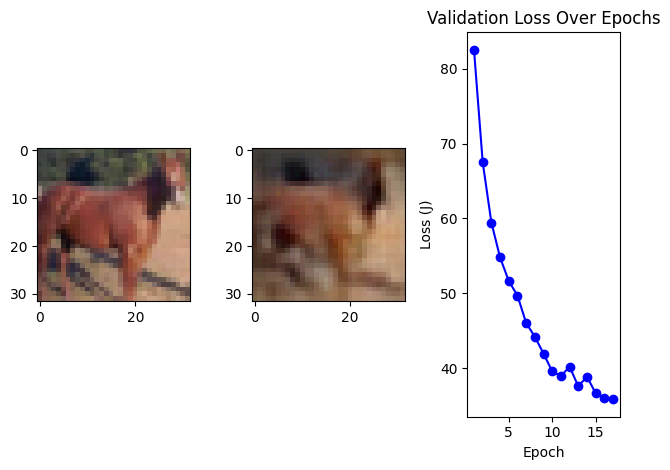

313/313 [==============================] - 53s 170ms/step - loss: 34.8705 - distortion_loss: 0.0639 - rate_loss: 2.8979 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 2.8981 - val_loss: 35.8583 - val_distortion_loss: 0.0658 - val_rate_loss: 2.9586 - val_distortion_pass_through_loss: 0.0658 - val_rate_pass_through_loss: 2.9589
Epoch: 17
Using weights previously generated
  6/313 [..............................] - ETA: 40s - loss: 33.1293 - distortion_loss: 0.0603 - rate_loss: 2.9572 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 2.9572

313/313 [==============================] - ETA: 0s - loss: 34.4527 - distortion_loss: 0.0631 - rate_loss: 2.9114 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 2.9115
Saved weights.
R=0.80078125 D=17.01704216003418 D+R=17.81782341003418 LATENT_SIZE=256


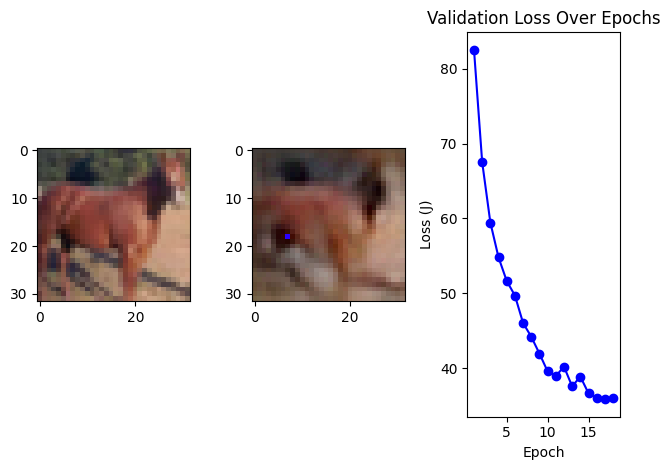

313/313 [==============================] - 53s 170ms/step - loss: 34.4527 - distortion_loss: 0.0631 - rate_loss: 2.9114 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 2.9115 - val_loss: 36.0094 - val_distortion_loss: 0.0662 - val_rate_loss: 2.9314 - val_distortion_pass_through_loss: 0.0662 - val_rate_pass_through_loss: 2.9317


KeyboardInterrupt: ignored

In [18]:
callbacks_list = [MyCallback()]
trainer = make_compression_trainer(lmbda=LAMBDA)
print("Epoch:", 0)
trainer.fit(
  training_dataset.map(add_rd_targets).batch(128).prefetch(8),
  epochs=1,
  validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
  validation_freq=1,
    verbose=1,
  callbacks=callbacks_list
)
trainer.analysis_transform.summary()
trainer.synthesis_transform.summary()
for i in range(1, EPOCHS):
  print("Epoch:", i)
  trainer.fit(
    training_dataset.map(add_rd_targets).batch(128).prefetch(8),
    epochs=1,
    validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
    validation_freq=1,
    verbose=1,
    callbacks=callbacks_list
  )
#trainer = train_model(lmbda=LAMBDA)

In [ ]:
class Compressor(tf.keras.Model):
  """Compresses images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

class Decompressor(tf.keras.Model):
  """Decompresses images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

def make_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = Compressor(trainer.analysis_transform, entropy_model)
  decompressor = Decompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_codec(trainer)

In [ ]:
def display_images(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((32, 32, 3), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        #.5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        .5, .5, f"{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

In [ ]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)
strings, entropies = compressor(originals)

print(f"String representation of first compressed image (in hexadecimal): 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")

reconstructions = decompressor(strings)
display_images(originals, strings, entropies, reconstructions)

In [ ]:
# Compare with JPEG

(originals, _), = validation_dataset.batch(16).skip(3).take(1)

reconstructions = []
entropies = []
for count, i in enumerate(originals):
  j = tf.image.encode_jpeg(i)
  k = tf.image.decode_jpeg(j)
  reconstructions.append(k)
  file_path = f"{count:02d}.jpg"
  with open(file_path, "wb") as file:
    file.write(j.numpy())
  length_j = tf.strings.length(j)*8
  entropies.append(length_j)

display_images(originals, strings, entropies, reconstructions)

In [ ]:
!ls -l